In [62]:
import numpy as np
import cv2
from skimage.morphology import skeletonize
import argparse

In [63]:
import matplotlib.pyplot as plt
def display_image(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [64]:
class test_input:
    input= 'images/sample11.png'
    corner= 1
    epsilon=1.5
    erosion=3

args = test_input()

In [65]:
source_path = args.input
corner = int(args.corner)
epsilon = float(args.epsilon)
erosion = int(args.erosion)

# Directions for path find
dx = [ 1,0,-1,0, 1,1,-1,-1]
dy = [ 0,1,0,-1, -1,1,1,-1]

size = 95*5     # PB-700 size


In [66]:
# Utility tracing function
def trace_single_line_from( img, x, y ):
    "Remove from image a path starting from x,y and returns it in array"
    h,w = img.shape
    result = []

    img[y,x] = 0
    result.append( [x,y] )
    finished = False
    while not finished:
        finished = True
        for d in range(8):
            vx = x+dx[d]
            vy = y+dy[d]
            if not (vx<0 or vx>=h or vy<0 or vy>=w):
                if img[vy,vx]==255:
                    x = vx
                    y = vy
                    img[y,x] = 0
                    result.append( [x,y] )
                    finished = False
                    break
    return result

# Main tracing function: we trace twice and join the two resulting paths
def trace_line_from( img, x, y ):
    "Remove from image a path containing x,y and returns it in array"
    h,w = img.shape
    result = []

    result = trace_single_line_from( img, x, y )
    result.reverse()
    result = result + trace_single_line_from( img, x, y )[1:]

    return result


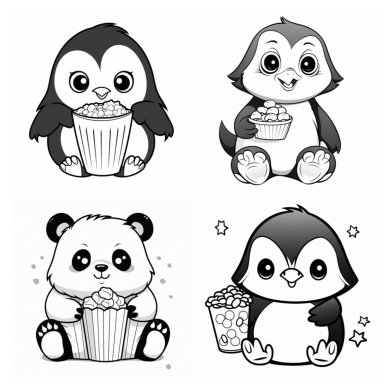

In [67]:
original = cv2.imread(source_path, cv2.IMREAD_COLOR)
display_image(original)


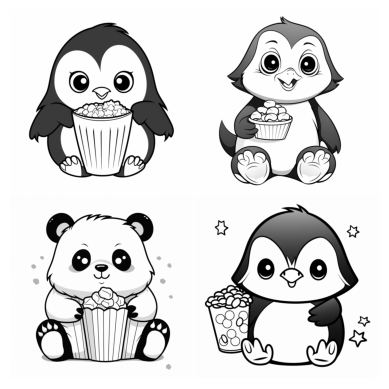

In [68]:
img = cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)
display_image(img)

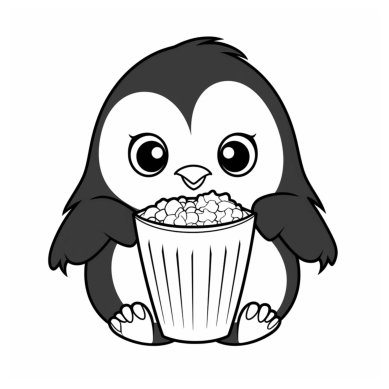

In [69]:
h,w = img.shape
if corner!=0:
    corners = [(0,0),(0,1),(1,0),(1,1)]
    c = corners[corner-1]
    start_row = h//2 * c[0]
    end_row = start_row + h//2
    start_col = w//2 * c[1]
    end_col = start_col + w//2
    img = img[start_row:end_row, start_col:end_col]

cv2.imwrite('/tmp/2-extract.png', img)

display_image(img)

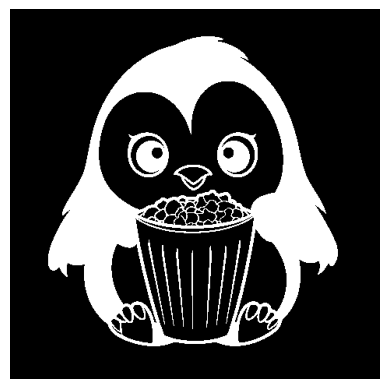

In [70]:
# Resize to PB-700 resolution
img = cv2.resize( img, (size,size), interpolation = cv2.INTER_AREA)
cv2.imshow('source grayscale', img) 
cv2.moveWindow( 'source grayscale',size,0)
cv2.imwrite('/tmp/3-475px.png', img)

img = 255-img

# Converting image to a binary image
# ( black and white only image).
_, threshold = cv2.threshold(img, 55, 255, cv2.THRESH_BINARY)

threshold = 255-threshold
threshold = 255-threshold

display_image(threshold)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

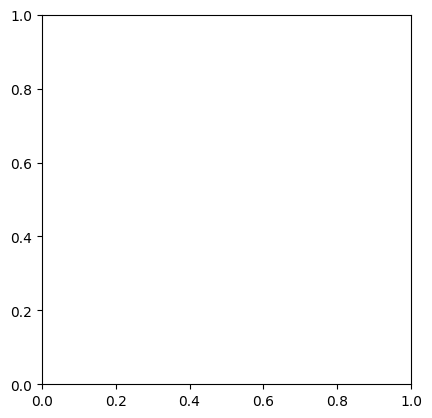

In [88]:
# Erodes black pixels based on a 3x3 grid (center stays black if all 9 pixels are black)
import scipy


def erode_black( img ):
    eroded = img.copy()
    h,w = img.shape
    eroded = np.zeros(shape=(h,w), dtype=np.uint8)

    for x in range(h):
        for y in range(w):
            black = 255
            for dx in [-1,0,1]:
                for dy in [-1,0,1]:
                    x0 = x+dx
                    y0 = y+dy
                    if not (x0<0 or x0>=w or y0<0 or y0>=h):
                        if black==255:
                            black = img[y0,x0]
            eroded[y,x] = black

    return eroded

def generate_convolution_matrix( iterations ):
    n = iterations*2+1
    result = np.array([[1./n/n]*n]*n)
    print(result)
    return result

erosion = 2
if erosion>0:
    matrix = generate_convolution_matrix(erosion)
    eroded = cv2.filter2D(threshold, -1, matrix)
    threshold -= eroded
    display_image(eroded)

# if erosion>0:
#     eroded = threshold
#     for i in range(erosion):
#         eroded = erode_black(eroded)
#     threshold -= eroded
#     eroded = 255-eroded
#     display_image(eroded)


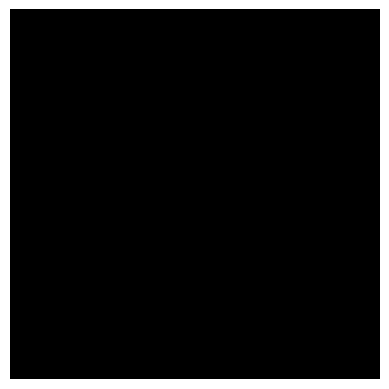

In [72]:
# Turn into skeleton
skeleton = cv2.ximgproc.thinning(threshold)

skeleton = 255-skeleton

display_image(skeleton)

skeleton = 255-skeleton



Total points== 0


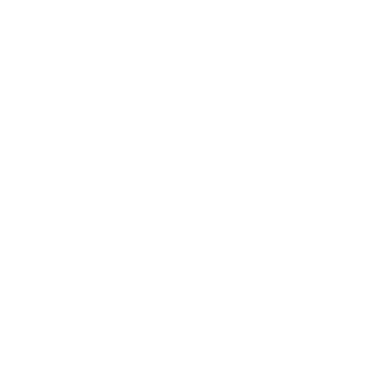

In [73]:
result = []
h,w = skeleton.shape
for y in range(w):
    for x in range(h):
        if skeleton[y,x]==255:
            line = np.array(trace_line_from( skeleton, x, y ))
            line = cv2.approxPolyDP(line, epsilon, False)
            result.append(line)

tot = 0
for c in result:
    tot += len(c)
print( "Total points==",tot )

# Draw result
img3 = 255 * np.ones(shape=(size,size,3), dtype=np.uint8)
cv2.polylines(img3, result, False, (0, 0, 0), 1)

display_image(img3)


In [74]:
def distance2( p0, p1 ):
    return (p0[0]-p1[0])*(p0[0]-p1[0])+(p0[1]-p1[1])*(p0[1]-p1[1])

class SegmentList:
    segments_ = []

    def __init__( self, segments ):
        for seg in segments:
                # Segments are one level too deep, for whatever reason
            self.segments_.append( list([p[0][0], p[0][1]] for p in seg) )

    def closest( self, x, y ):
        d = 10240*10240
        index = 0
        for i in range(len(self.segments_)):
            d0 = distance2( self.segments_[i][0], (x,y) )
            d1 = distance2( self.segments_[i][-1], (x,y) )
            if (d0<d):
                index = i
                d = d0

            if (d1<d):
                index = i
                d = d1
                self.segments_[i].reverse()

        return self.segments_.pop(index)

    def done( self ):
        return len(self.segments_)==0

sl = SegmentList( result )

# Generating the BASIC program for the PB-700

class Generator:
    line_ = 2
    string_ = '1LPRINT CHR$(28);CHR$(37):LPRINT"O0,-96"\n'

    def add_small_segment( self, s ):
        self.string_ += str(self.line_)+'LPRINT"D'
        self.line_ += 1
        sep = ""
        for p in s:
            self.string_ += sep
            sep = ","
            self.string_ += str(p[0]/5)+","+str((size-p[1])/5)
        self.string_ += '"\n'

    def add_segment( self, s ):
        while (len(s)>1):
            self.add_small_segment( s[:6] )
            s = s[5:]

    def end( self ):
        self.string_ += '999LPRINT"M0,-20"\n'

    def string( self ):
        return self.string_


1LPRINT CHR$(28);CHR$(37):LPRINT"O0,-96"
999LPRINT"M0,-20"



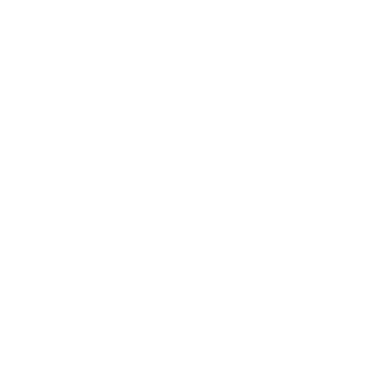

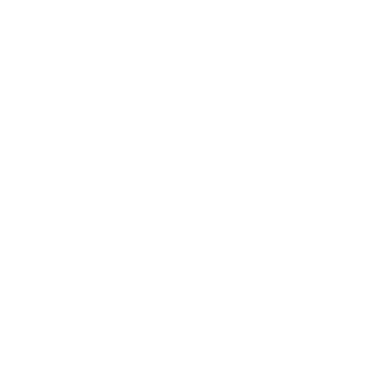

In [75]:
g = Generator()

segment_img = 255 * np.ones(shape=(size,size,3), dtype=np.uint8)
x = 0
y = 0
i = 0
while not sl.done():
    cur = sl.closest( x, y )
    g.add_segment( cur )

    # Draw the motion
    cv2.line(img3, (x, y), (cur[0][0], cur[0][1]), (192,192,192), thickness=1)

    # Draw all segments with different colors
    c = [(255, 0, 0),(0, 255, 0),(0, 0, 255),(255,255,0),(255,0,255)][i%5]
    i = i+1
    for j in range(len(cur)-1):
        # cv2.polylines(img3, [cur], False, c, 1)
        cv2.line(img3, (cur[j][0], cur[j][1]), (cur[j+1][0], cur[j+1][1]), c, thickness=1)
        cv2.line(segment_img, (cur[j][0], cur[j][1]), (cur[j+1][0], cur[j+1][1]), c, thickness=1)

    x = cur[-1][0]
    y = cur[-1][1]
g.end()

print( g.string() )

display_image(segment_img)
display_image(img3)
